# Imports

In [37]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# Core Simulation Logic

In [38]:
def run_experiment(num_bins, num_balls, strategy, extra_params=None):
    bins = [0] * num_bins
    
    if extra_params is None:
        extra_params = {}
    
    beta = extra_params.get('beta', 0.5)
    k = extra_params.get('k', 1) 
    batch_size = extra_params.get('batch_size', 1)
    
    balls_used = 0
    
    while balls_used < num_balls:
        this_batch = min(batch_size, num_balls - balls_used)
        
        if batch_size > 1 or strategy == "partial_info":
            bin_snapshot = bins.copy()
            if strategy == "partial_info":
                median = np.median(bin_snapshot)
                Q1_load = np.percentile(bin_snapshot, 25) # 75% most loaded are >= Q1
                Q3_load = np.percentile(bin_snapshot, 75) # 25% most loaded are >= Q3
        else:
            bin_snapshot = bins
        
        for _ in range(this_batch):
            chosen_bin = -1
            
            if strategy == "one_choice":
                chosen_bin = random.randint(0, num_bins - 1)
                
            elif strategy == "d_choice":
                random_bins = [random.randint(0, num_bins - 1) for _ in range(2)]
                
                if bin_snapshot[random_bins[0]] < bin_snapshot[random_bins[1]]:
                    chosen_bin = random_bins[0]
                elif bin_snapshot[random_bins[1]] < bin_snapshot[random_bins[0]]:
                    chosen_bin = random_bins[1]
                else:
                    chosen_bin = random.choice(random_bins)
                
            elif strategy == "one_plus_beta":
                if random.random() < beta:
                    random_bins = [random.randint(0, num_bins - 1) for _ in range(2)]
                    
                    if bin_snapshot[random_bins[0]] < bin_snapshot[random_bins[1]]:
                        chosen_bin = random_bins[0]
                    elif bin_snapshot[random_bins[1]] < bin_snapshot[random_bins[0]]:
                        chosen_bin = random_bins[1]
                    else:
                        chosen_bin = random.choice(random_bins)
                else:
                    chosen_bin = random.randint(0, num_bins - 1)
                    
            elif strategy == "partial_info":
                random_bins = [random.randint(0, num_bins - 1) for _ in range(2)]
                b1, b2 = random_bins[0], random_bins[1]
                
                b1_above = bin_snapshot[b1] > median
                b2_above = bin_snapshot[b2] > median
                
                if b1_above != b2_above:
                    chosen_bin = b2 if b1_above else b1
                else:
                    if k == 1:
                        chosen_bin = random.choice(random_bins)
                    else:
                        if not b1_above:
                            b1_in_top75 = bin_snapshot[b1] >= Q1_load
                            b2_in_top75 = bin_snapshot[b2] >= Q1_load
                            
                            if b1_in_top75 != b2_in_top75:
                                chosen_bin = b2 if b1_in_top75 else b1
                            else:
                                chosen_bin = random.choice(random_bins)
                        else:
                            b1_in_top25 = bin_snapshot[b1] >= Q3_load
                            b2_in_top25 = bin_snapshot[b2] >= Q3_load
                            
                            if b1_in_top25 != b2_in_top25:
                                chosen_bin = b2 if b1_in_top25 else b1
                            else:
                                chosen_bin = random.choice(random_bins)
            
            bins[chosen_bin] += 1
            balls_used += 1
    
    max_load = max(bins)
    avg_load = num_balls / num_bins
    gap = max_load - avg_load
    
    return gap

def run_multiple_trials(num_bins, num_balls_list, strategy, num_trials=10, extra_params=None):
    avg_gaps = []
    std_gaps = []
    
    print(f"--- Running Strategy: {strategy}, Params: {extra_params or {}} ---")
    start_time = time.time()
    
    for num_balls in num_balls_list:
        gaps = []
        for _ in range(num_trials):
            gap = run_experiment(num_bins, num_balls, strategy, extra_params) 
            gaps.append(gap)
        
        average_gap = sum(gaps) / len(gaps)
        variance = sum((x - average_gap) ** 2 for x in gaps) / len(gaps)
        std_dev = variance ** 0.5
        
        avg_gaps.append(average_gap)
        std_gaps.append(std_dev)
    
    end_time = time.time()
    print(f"--- Completed in {end_time - start_time:.2f} seconds ---")
    
    return avg_gaps, std_gaps

# Plotting Utility Function

In [39]:
def make_plot(results, m, title, filename="plot.png", use_log_scale=True):
    plt.figure(figsize=(14, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
    
    for i, (name, x, y_avg, y_std) in enumerate(results):
        c = colors[i]
        plt.plot(x, y_avg, label=name, color=c, marker='o', markersize=4)
        
        low = [a - s for a, s in zip(y_avg, y_std)]
        high = [a + s for a, s in zip(y_avg, y_std)]
        plt.fill_between(x, low, high, alpha=0.15, color=c)
    
    plt.axvline(x=m, color='gray', linestyle='--', linewidth=2, label=f'n=m={m} (light load)')
    
    plt.xlabel('Number of Balls (n)')
    plt.ylabel('Average Gap (Max Load - n/m)')
    plt.title(title)
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    if use_log_scale:
        plt.xscale('log')
        
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Experiment Setup

In [40]:
num_bins = 50   # m
num_trials = 50 # T

# Generate n values from n=m to n=m^2
m = num_bins
m_squared = num_bins**2

n_values = [50, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]

print(f"Running experiments with m={m} bins and T={num_trials} trials.")
print(f"n values (from n=m to n=m^2): {n_values}")

all_results = []

Running experiments with m=50 bins and T=50 trials.
n values (from n=m to n=m^2): [50, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500]


## Experiment 1: Standard Strategies

--- Running Strategy: one_choice, Params: {} ---
--- Completed in 0.27 seconds ---
--- Running Strategy: d_choice, Params: {} ---
--- Completed in 0.54 seconds ---
--- Running Strategy: one_plus_beta, Params: {'beta': 0.3} ---
--- Completed in 0.42 seconds ---
--- Running Strategy: one_plus_beta, Params: {'beta': 0.5} ---
--- Completed in 0.43 seconds ---
--- Running Strategy: one_plus_beta, Params: {'beta': 0.8} ---
--- Completed in 0.50 seconds ---


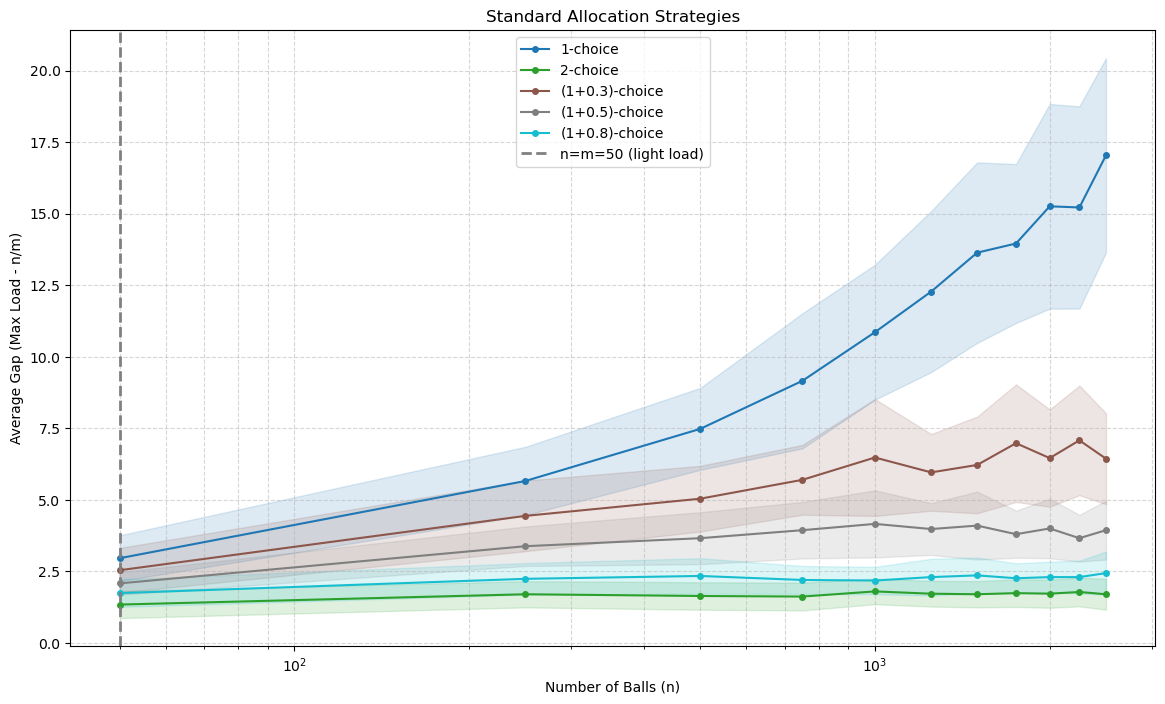

In [ ]:
# 1. One-choice (baseline) 
avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "one_choice", num_trials)
all_results.append(("1-choice", n_values, avg_gaps, std_gaps))
    
# 2. Two-choice 
avg_gaps, std_gaps = run_multiple_trials(num_bins, n_values, "d_choice", num_trials)
all_results.append(("2-choice", n_values, avg_gaps, std_gaps))
    
# 3. (1+beta) strategies 
for beta in [0.3, 0.5, 0.8]:
    avg_gaps, std_gaps = run_multiple_trials(
        num_bins, n_values, "one_plus_beta", num_trials, {'beta': beta}
    )
    all_results.append((f"(1+{beta})-choice", n_values, avg_gaps, std_gaps))

make_plot(all_results, num_bins, "Standard Allocation Strategies", filename="standard_strategies.png")

## Experiment 2: Batched Strategies

--- Running Strategy: one_choice, Params: {'batch_size': 50} ---
--- Completed in 0.18 seconds ---
--- Running Strategy: one_choice, Params: {'batch_size': 100} ---
--- Completed in 0.17 seconds ---
--- Running Strategy: one_choice, Params: {'batch_size': 250} ---
--- Completed in 0.23 seconds ---
--- Running Strategy: one_choice, Params: {'batch_size': 500} ---
--- Completed in 0.18 seconds ---
--- Running Strategy: one_choice, Params: {'batch_size': 1000} ---
--- Completed in 0.23 seconds ---
--- Running Strategy: one_choice, Params: {'batch_size': 2500} ---
--- Completed in 0.28 seconds ---
--- Running Strategy: one_choice, Params: {'batch_size': 3500} ---
--- Completed in 0.18 seconds ---
--- Running Strategy: d_choice, Params: {'batch_size': 50} ---
--- Completed in 0.44 seconds ---
--- Running Strategy: d_choice, Params: {'batch_size': 100} ---
--- Completed in 0.43 seconds ---
--- Running Strategy: d_choice, Params: {'batch_size': 250} ---
--- Completed in 0.46 seconds ---
--- R

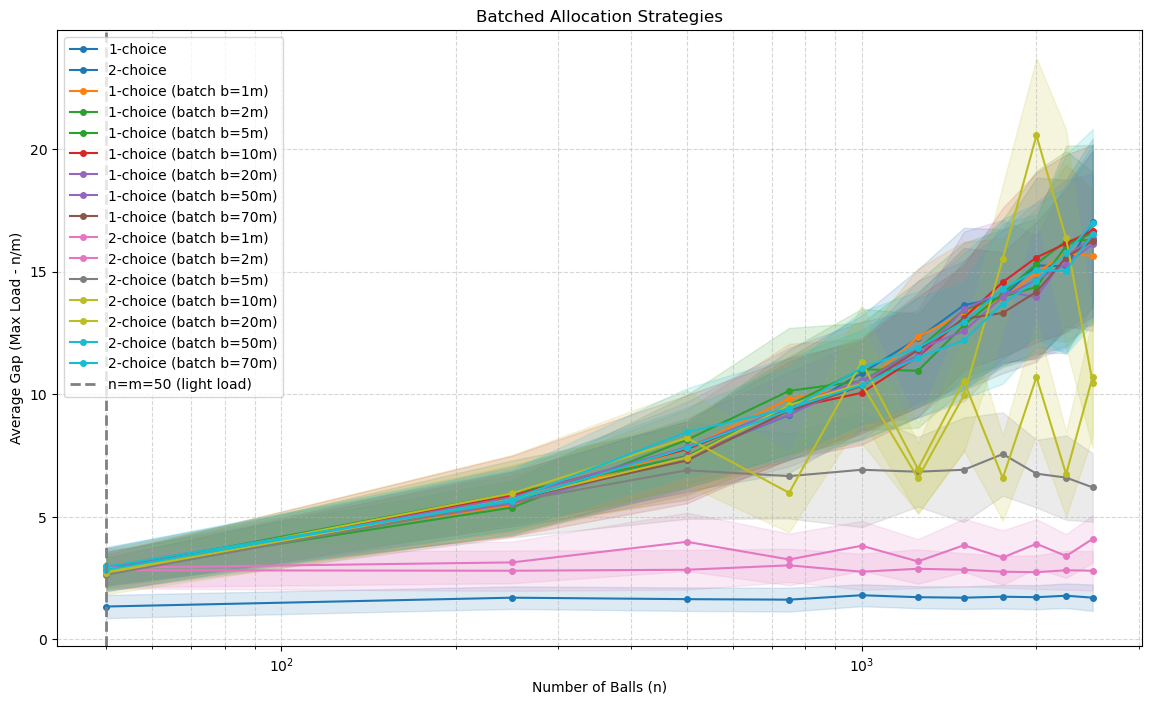

In [42]:
#batch_sizes = [50, 100, 250, 500] # m, 2m, 5m, 10m
batch_sizes = [m * k for k in [1, 2, 5, 10, 20, 50, 70]]

batched_results = []


# 1. Batched One-Choice
for b in batch_sizes:
    avg_gaps, std_gaps = run_multiple_trials(
        num_bins, n_values, "one_choice", num_trials, {'batch_size': b}
    )
    label = f"1-choice (batch b={b//num_bins}m)"
    batched_results.append((label, n_values, avg_gaps, std_gaps))

# 2. Batched Two-Choice
for b in batch_sizes:
    avg_gaps, std_gaps = run_multiple_trials(
        num_bins, n_values, "d_choice", num_trials, {'batch_size': b}
    )
    label = f"2-choice (batch b={b//num_bins}m)"
    batched_results.append((label, n_values, avg_gaps, std_gaps))

# Plot batched results vs. non-batched
plot_data = [
    all_results[0], # Standard 1-choice
    all_results[1]  # Standard 2-choice
] + batched_results
make_plot(plot_data, num_bins, "Batched Allocation Strategies", filename="batched_strategies.png")

 ## Experiment 3: Partial Information Strategies

--- Running Strategy: partial_info, Params: {'k': 1} ---
--- Completed in 48.63 seconds ---
--- Running Strategy: partial_info, Params: {'k': 2} ---
--- Completed in 48.65 seconds ---


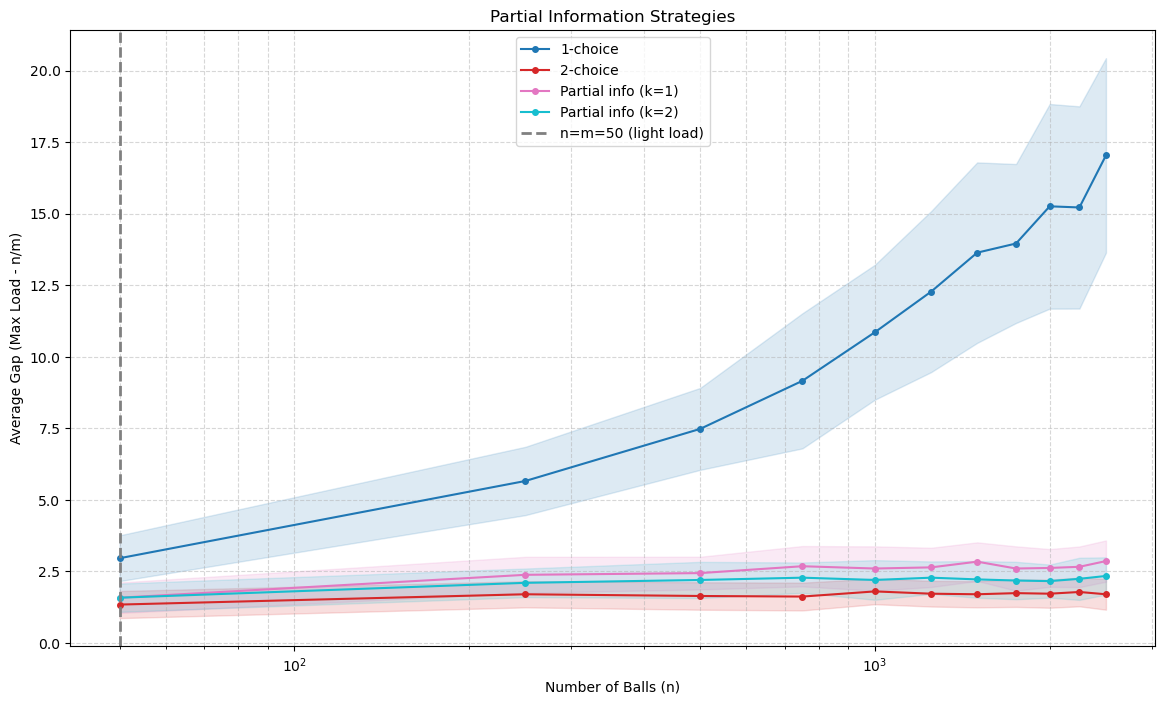

In [43]:
partial_info_results = []

avg_gaps, std_gaps = run_multiple_trials(
    num_bins, n_values, "partial_info", num_trials, {'k': 1}
)
partial_info_results.append(("Partial info (k=1)", n_values, avg_gaps, std_gaps))
    
# Run experiment for k=2 
avg_gaps, std_gaps = run_multiple_trials(
    num_bins, n_values, "partial_info", num_trials, {'k': 2}
)
partial_info_results.append(("Partial info (k=2)", n_values, avg_gaps, std_gaps))

# Plot partial info vs. standard 1-choice and 2-choice
plot_data = [
    all_results[0], # Standard 1-choice
    all_results[1]  # Standard 2-choice
] + partial_info_results
make_plot(plot_data, num_bins, "Partial Information Strategies", filename="partial_info.png")

## Final Combined Plot

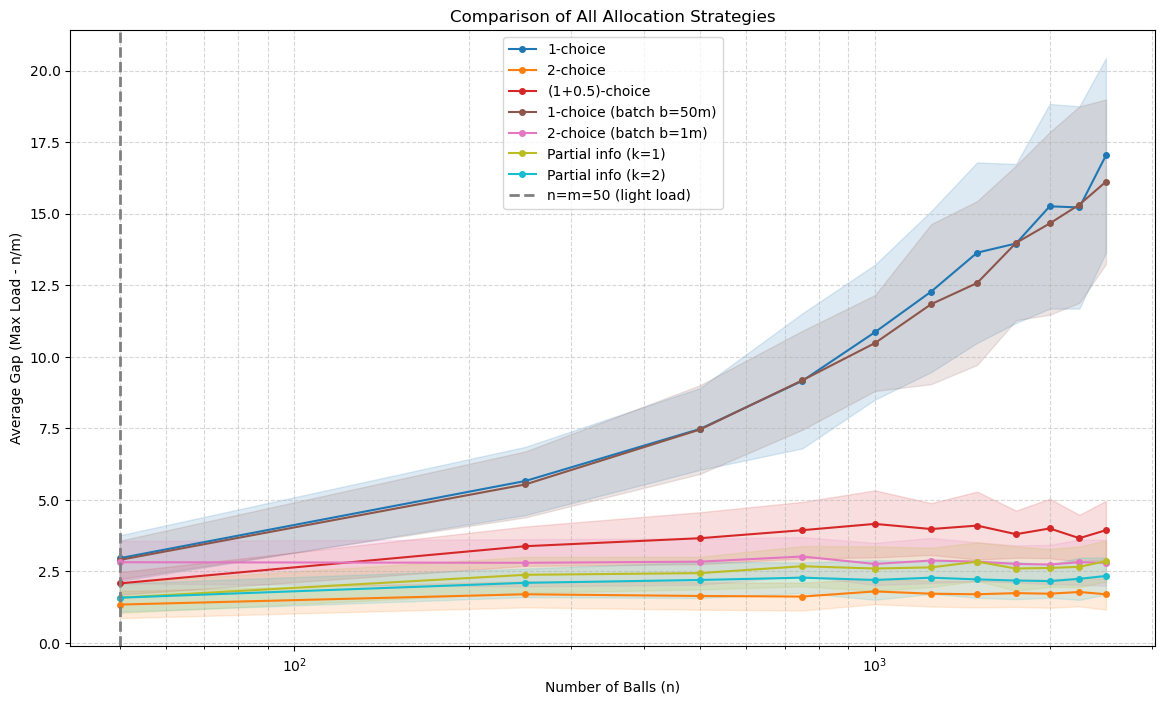

In [44]:
final_plot_data = [
    all_results[0], # 1-choice
    all_results[1], # 2-choice
    all_results[3], # (1+0.5)-choice
    batched_results[5], # 2-choice (batch b=2m)
    batched_results[7], # 2-choice (batch b=10m)
    partial_info_results[0], # Partial info (k=1)
    partial_info_results[1], # Partial info (k=2)
]

make_plot(final_plot_data, num_bins, "Comparison of All Allocation Strategies", filename="combined_plot.png")

# Data Analysis (Table)

In [45]:
df_results = pd.DataFrame({'n': n_values})

for name, x, y_avg, y_std in all_results + batched_results + partial_info_results:
    if name not in df_results.columns:
        df_results[name + '_avg_gap'] = y_avg
        df_results[name + '_std_dev'] = y_std

df_results = df_results.set_index('n')

print(f"--- Gap at n=m={m} (Light Load) ---")
print(df_results.loc[m][[col for col in df_results.columns if 'avg_gap' in col]].sort_values())
print("\n")
print(f"--- Gap at n=m^2={m_squared} (Heavy Load) ---")
print(df_results.loc[m_squared][[col for col in df_results.columns if 'avg_gap' in col]].sort_values())

print("\n--- Full Data Table (Average Gaps) ---")
pd.set_option('display.max_columns', None)
display(df_results[[col for col in df_results.columns if 'avg_gap' in col]].style.background_gradient(cmap='viridis', axis=1))

--- Gap at n=m=50 (Light Load) ---
2-choice_avg_gap                  1.34
Partial info (k=2)_avg_gap        1.58
Partial info (k=1)_avg_gap        1.58
(1+0.8)-choice_avg_gap            1.74
(1+0.5)-choice_avg_gap            2.08
(1+0.3)-choice_avg_gap            2.54
2-choice (batch b=5m)_avg_gap     2.64
1-choice (batch b=70m)_avg_gap    2.72
2-choice (batch b=20m)_avg_gap    2.72
1-choice (batch b=20m)_avg_gap    2.76
2-choice (batch b=10m)_avg_gap    2.76
1-choice (batch b=2m)_avg_gap     2.80
2-choice (batch b=1m)_avg_gap     2.82
2-choice (batch b=70m)_avg_gap    2.84
1-choice (batch b=5m)_avg_gap     2.84
1-choice (batch b=10m)_avg_gap    2.84
1-choice (batch b=50m)_avg_gap    2.90
2-choice (batch b=2m)_avg_gap     2.92
1-choice_avg_gap                  2.96
2-choice (batch b=50m)_avg_gap    2.98
1-choice (batch b=1m)_avg_gap     3.00
Name: 50, dtype: float64


--- Gap at n=m^2=2500 (Heavy Load) ---
2-choice_avg_gap                   1.70
Partial info (k=2)_avg_gap         2.34


,1-choice_avg_gap,2-choice_avg_gap,(1+0.3)-choice_avg_gap,(1+0.5)-choice_avg_gap,(1+0.8)-choice_avg_gap,1-choice (batch b=1m)_avg_gap,1-choice (batch b=2m)_avg_gap,1-choice (batch b=5m)_avg_gap,1-choice (batch b=10m)_avg_gap,1-choice (batch b=20m)_avg_gap,1-choice (batch b=50m)_avg_gap,1-choice (batch b=70m)_avg_gap,2-choice (batch b=1m)_avg_gap,2-choice (batch b=2m)_avg_gap,2-choice (batch b=5m)_avg_gap,2-choice (batch b=10m)_avg_gap,2-choice (batch b=20m)_avg_gap,2-choice (batch b=50m)_avg_gap,2-choice (batch b=70m)_avg_gap,Partial info (k=1)_avg_gap,Partial info (k=2)_avg_gap
n,,,,,,,,,,,,,,,,,,,,,
50,2.960000,1.340000,2.540000,2.080000,1.740000,3.000000,2.800000,2.840000,2.840000,2.760000,2.900000,2.720000,2.820000,2.920000,2.640000,2.760000,2.720000,2.980000,2.840000,1.580000,1.580000
250,5.660000,1.700000,4.440000,3.380000,2.240000,5.480000,5.380000,5.960000,5.860000,5.800000,5.540000,5.720000,2.800000,3.140000,5.620000,5.960000,5.720000,5.640000,5.700000,2.380000,2.100000
500,7.480000,1.640000,5.040000,3.660000,2.340000,7.780000,8.140000,7.480000,7.760000,7.840000,7.460000,7.300000,2.840000,3.980000,6.900000,8.220000,7.420000,7.820000,8.460000,2.440000,2.200000
750,9.160000,1.620000,5.700000,3.940000,2.200000,9.820000,10.140000,9.560000,9.420000,9.480000,9.180000,9.340000,3.020000,3.260000,6.660000,5.980000,9.560000,9.360000,9.420000,2.680000,2.280000
1000,10.860000,1.800000,6.480000,4.160000,2.180000,10.340000,10.540000,11.020000,10.060000,10.580000,10.480000,10.340000,2.760000,3.820000,6.920000,11.320000,10.420000,11.080000,10.380000,2.600000,2.200000
1250,12.280000,1.720000,5.960000,3.980000,2.300000,12.340000,11.840000,10.960000,11.540000,11.560000,11.840000,11.800000,2.880000,3.180000,6.840000,6.960000,6.580000,11.900000,11.500000,2.640000,2.280000
1500,13.640000,1.700000,6.220000,4.100000,2.360000,13.320000,13.440000,12.820000,13.120000,13.460000,12.580000,13.080000,2.840000,3.840000,6.920000,10.540000,9.960000,12.960000,12.200000,2.840000,2.220000
1750,13.960000,1.740000,6.980000,3.800000,2.260000,13.900000,13.980000,14.120000,14.580000,14.220000,13.980000,13.320000,2.760000,3.340000,7.560000,6.580000,15.540000,14.300000,13.700000,2.600000,2.180000
2000,15.260000,1.720000,6.460000,4.000000,2.300000,14.960000,14.380000,15.320000,15.580000,13.960000,14.660000,14.180000,2.740000,3.900000,6.760000,10.700000,20.560000,15.060000,14.640000,2.620000,2.160000
